# Visualising and saving analysis regions for the samples

This notebook exists only to generate combined (stacked or co-added) images of the galaxy clusters in our samples. The visualisations will have the initial $R_{500}$ and background regions overlaid, as well as contaminant source regions. They will then be saved to disk for future access/reference.

## Import Statements

In [11]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError
from astropy.cosmology import LambdaCDM, WMAP9
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
import warnings
warnings.filterwarnings('ignore')

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import xcs3p_colour, xcs_cosmo, xxlgc100_colour, xxl_cosmo, locuss_colour, locuss_cosmo

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.products import Image
from xga.imagetools.misc import physical_rad_to_pix

## Defining useful functions

In [12]:
def analysis_regions_visualisation(src, save_path, view=False):
    rt = src.get_combined_ratemaps()
    src_msk, bck_msk = src.get_mask('r500')
    int_msk = src.get_interloper_mask()
    
    rpix = physical_rad_to_pix(rt, src.r500, src.default_coord, src.redshift, src.cosmo)
    src_ann = Quantity([0, rpix.value], 'pix')
    bck_ann = Quantity(rpix*src.background_radius_factors)
    rt.regions = src._interloper_regions
    
    coords = Quantity([src.peak, src.ra_dec])

    if view:
        rt.view(coords, int_msk, radial_bins_pix=src_ann.value, back_bin_pix=bck_ann.value, zoom_in=True, 
                view_regions=True)
    else:
        rt.save_view(save_path, coords, int_msk, radial_bins_pix=src_ann.value, back_bin_pix=bck_ann.value, 
                     zoom_in=True, view_regions=True)
    plt.close('all')

## Reading in Sample Files and Declaring XGA ClusterSamples

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### SDSSRM-XCS Volume Limited

This is the recent SDSSRM-XCS sample. The temperatures and luminosities are measured by the XCS luminosity-temperature pipeline, and with this we demonstrate that XGA temperatures and luminosities are consistent with existing XCS results.

In order to achieve maximum consistency, we use the XAPA coordinates as the central position for spectrum generation (turning off the XGA peak finder with `use_peak=False`). We have also made sure to use the same cosmology.

In [3]:
xcs3p = pd.read_csv("../../sample_files/xcs3p_sdssrm_vol_lim_temperr_25%_clusters.csv")

In [4]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xcs3p['xapa_ra'].values
dec = xcs3p['xapa_dec'].values
z = xcs3p['z'].values
# Not using the IAU names in XCS_NAME column, its easier for me to use the name based on redMaPPer ID
n = xcs3p['name'].values
# In arcminutes, ClusterSample declaration will convert to kpc using the provided cosmology
r500 = Quantity(xcs3p['r500'].values, 'arcmin')
# Not likely to use richness in this notebook, but I'm putting it in the sample object anyway
r = xcs3p['richness'].values
r_err = xcs3p['richness_err'].values

# Declaring the actual ClusterSample instance for the XCS sample
xcs_srcs = ClusterSample(ra, dec, z, n, r500=r500, richness=r, richness_err=r_err, cosmology=xcs_cosmo, 
                         load_fits=True, use_peak=True, clean_obs=True, clean_obs_reg='r500', 
                         clean_obs_threshold=0.7)

Setting up Galaxy Clusters: 100%|███████████████████████████████████████████| 150/150 [14:30<00:00,  5.80s/it]


### XXL-100-GC

This is the sample of the brightest clusters in the XXL survey. It contains temperature and luminosity measurements, and will be a useful external comparison for XGA results, though the shallow XXL data may prove a challenge.

In [5]:
xxlgc100 = pd.read_csv("../../sample_files/xxl_gc100.csv")

# Limit the comparison to clusters with a flag of 0 - meaning it is in the main sample of 100 clusters
xxlgc100 = xxlgc100[xxlgc100['Flag'] == 0]

# Excluding a specific cluster which was excluded in the XXL analysis
xxlgc100 = xxlgc100[xxlgc100['XLSSC'] != 504]

In [6]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = xxlgc100['ra'].values
dec = xxlgc100['dec'].values
z = xxlgc100['z'].values
n = xxlgc100['name'].values
r500 = Quantity(xxlgc100['r500MT'].values, 'Mpc')

# Declaring the actual ClusterSample instance for the XXL sample
# This is the only sample whose original analysis used the WMAP9 cosmology
xxl_srcs = ClusterSample(ra, dec, z, n, r500=r500, cosmology=xxl_cosmo, load_fits=True, use_peak=True, 
                         clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Setting up Galaxy Clusters: 100%|█████████████████████████████████████████████| 99/99 [14:08<00:00,  8.57s/it]


### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [7]:
locuss = pd.read_csv("../../sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [8]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=True, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample: 100%|████████████████████████████████████████████| 50/50 [09:44<00:00, 11.70s/it]
Setting up Galaxy Clusters: 50it [07:54,  9.50s/it]                                                           


## Visualising $R_{500}$ and $R^{\rm{background}}_{500}$ regions

Here we generate combined ratemaps for all the clusters in the samples, overlaying the $R_{500}$ analysis region (as a solid circle), the background annulus (enclosed by two dashed circles) which by default goes from [1.05-1.5]$R_{500}$, the X-ray peak coordinate measured by XGA (the solid white crosshair), and the original literature coordinate (the dashed white crosshair).

We also mask the regions that XGA has defined as contaminants, and overlay their XCS region. Due to the large number of clusters in our various samples, we only display one cluster per sample here (as an example), and save all visualisations to the `cluster_visualisations/{sample name}` directories:

In [9]:
if not os.path.exists('../../outputs/cluster_visualisations/sdssrm-xcs'):
    os.makedirs('../../outputs/cluster_visualisations/sdssrm-xcs')

if not os.path.exists('../../outputs/cluster_visualisations/xxl'):
    os.makedirs('../../outputs/cluster_visualisations/xxl')
    
if not os.path.exists('../../outputs/cluster_visualisations/locuss'):
    os.makedirs('../../outputs/cluster_visualisations/locuss')

### SDSSRM-XCS Volume Limited

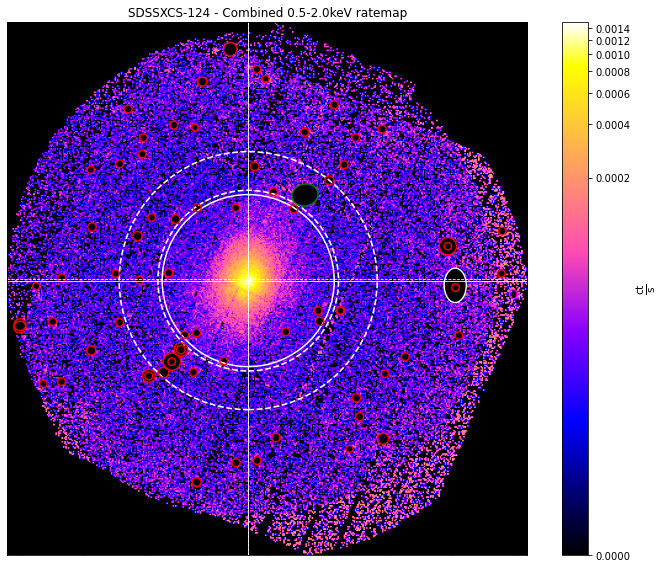

In [13]:
analysis_regions_visualisation(xcs_srcs[0], 
                               '../../outputs/cluster_visualisations/sdssrm-xcs/{}.png'.format(xcs_srcs[0].name), 
                               view=True)
for src in xcs_srcs:
    analysis_regions_visualisation(src, '../../outputs/cluster_visualisations/sdssrm-xcs/{}.png'.format(src.name))

### XXL-100-GC

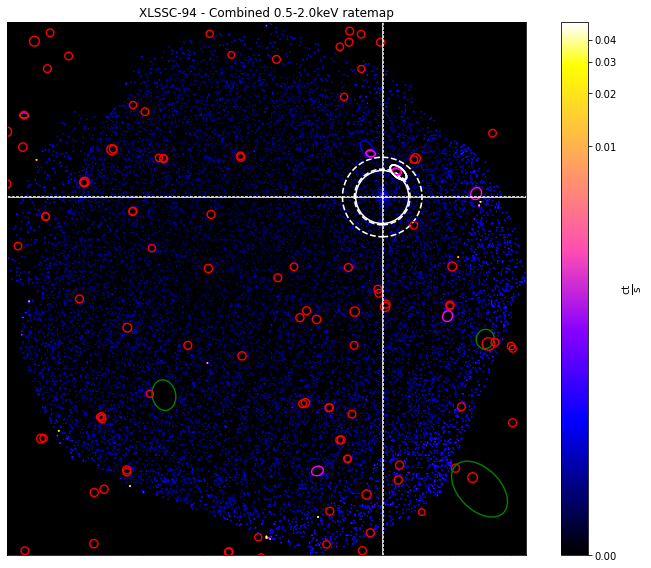

In [14]:
analysis_regions_visualisation(xxl_srcs[0], 
                               '../../outputs/cluster_visualisations/xxl/{}.png'.format(xxl_srcs[0].name), 
                               view=True)
for src in xxl_srcs:
    analysis_regions_visualisation(src, '../../outputs/cluster_visualisations/xxl/{}.png'.format(src.name))

### LoCuSS High-$L_{\rm{X}}$

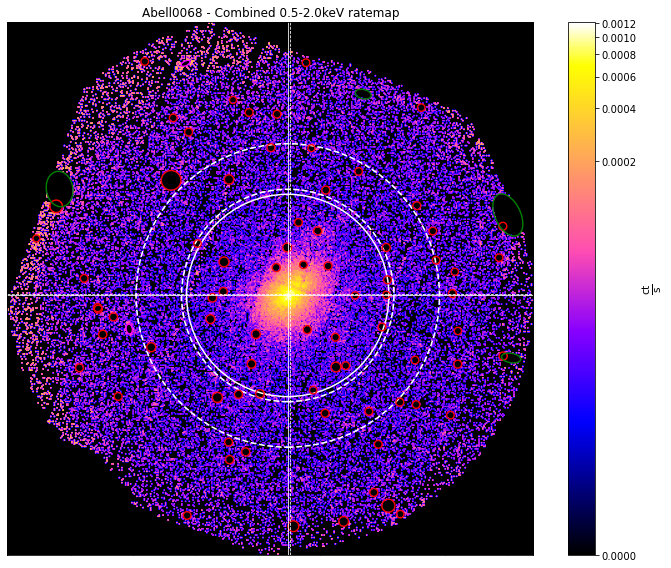

In [15]:
analysis_regions_visualisation(locuss_srcs[1], 
                               '../../outputs/cluster_visualisations/locuss/{}.png'.format(locuss_srcs[0].name), 
                               view=True)
for src in locuss_srcs:
    analysis_regions_visualisation(src, '../../outputs/cluster_visualisations/locuss/{}.png'.format(src.name))